## AI28 - Projet - Prédiction du niveau de revenus.

In [41]:
# pip install ucimlrepo

In [42]:
# OS
import sys


# WARNINGS
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('error', category=DeprecationWarning)

# NUMPY
import numpy as np

# STATS
import scipy.stats as stats
from scipy.stats import norm, skew

# MATPLOTLIB
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight') 

params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (10, 8)}
plt.rcParams.update(params)


# PANDAS
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None) 

# SEABORN 
import seaborn as sns
# sns.set_context("poster")
# sns.set_style("ticks")

# SCHIKIT-LEARN: PRE-PROCESSING
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder # Encodage des variables catégorielles ordinales
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder # Encodage des variables catégorielles nominales
from sklearn.preprocessing import StandardScaler # Standardisation des variables numériques
from sklearn.preprocessing import MinMaxScaler # Normalisation MinMax
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer # Imputation
from sklearn.impute import KNNImputer 


# SCHIKIT-LEARN: MODELES
from sklearn import linear_model # Classe Modèle linéaire 
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso 
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR 
from sklearn.neighbors import KNeighborsRegressor


# SCHIKIT-LEARN: VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score # Validation croisée pour comparaison entre modèles
from sklearn.model_selection import validation_curve # Courbe de validation: visualiser les scores lors du choix d'un hyperparamétre
from sklearn.model_selection import GridSearchCV # Tester plusieurs hyperparamètres
from sklearn.model_selection import RandomizedSearchCV # Tester plusieurs hyperparamètres
from sklearn.model_selection import learning_curve # Courbe d'apprentissage: visualisation des scores du train et du validation sets en fonction des quantités des données
import optuna
 
## EVALUATION

from sklearn.metrics import r2_score, accuracy_score, recall_score, precision_score  # Coefficient R2
from sklearn.metrics import mean_absolute_error #  MAE
from sklearn.metrics import mean_squared_error  # RMSE
from sklearn.metrics import median_absolute_error # Erreur de la médiane absolue

# SCHIKIT-LEARN: PIPELINE AND TRANSFORMATEUR
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# SOURCE DATA
from ucimlrepo import fetch_ucirepo 

In [43]:
# Utilisation des commandes fournies par UCI

# Télécharger le jeu de données 
data_adult = fetch_ucirepo(id=2) 

In [44]:
# data (as pandas dataframes) 
x = data_adult.data.features # variables explicatives
y = data_adult.data.targets # variables cibles

In [45]:
# metadata 
print(data_adult.metadata) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [46]:
# variable information 
print(data_adult.variables) 

              name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                       

## Analyse exploratoire des données

Pour réaliser l'AED, nous utilisons les données des fichiers téléchargés depuis le site web.

In [47]:
df_adult = pd.read_csv("./Data/adult.data", header=None)

In [48]:
isinstance(df_adult, pd.DataFrame)

True

Le fichier ne contient pas les noms des colonnes. Nous les ajoutons dans le dataframe adult.

In [49]:
adult_columns = data_adult.variables['name']

df_adult.columns = adult_columns

df_adult.head()

name,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [50]:
df_adult.shape

(32561, 15)

In [51]:
df_adult.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object', name='name')

In [52]:
df_adult.describe()

name,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [53]:
df_adult.isna().sum()

name
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [54]:
df_adult = df_adult.drop_duplicates()
df_adult[df_adult.duplicated()]

name,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income


In [55]:
df_adult.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32537 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32537 non-null  int64 
 1   workclass       32537 non-null  object
 2   fnlwgt          32537 non-null  int64 
 3   education       32537 non-null  object
 4   education-num   32537 non-null  int64 
 5   marital-status  32537 non-null  object
 6   occupation      32537 non-null  object
 7   relationship    32537 non-null  object
 8   race            32537 non-null  object
 9   sex             32537 non-null  object
 10  capital-gain    32537 non-null  int64 
 11  capital-loss    32537 non-null  int64 
 12  hours-per-week  32537 non-null  int64 
 13  native-country  32537 non-null  object
 14  income          32537 non-null  object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB


Problème : La description des données indique qu'elles contiennent des valeurs inconnues. Ces valeurs ne sont pas en NaN ou null. Nous pouvons déjà remarquer la présence de '?' en leur lieu et place.

## Traitement des données

### Analyse des traitements à réaliser

Nombre de valeurs manquantes : name
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     582
income               0
dtype: int64


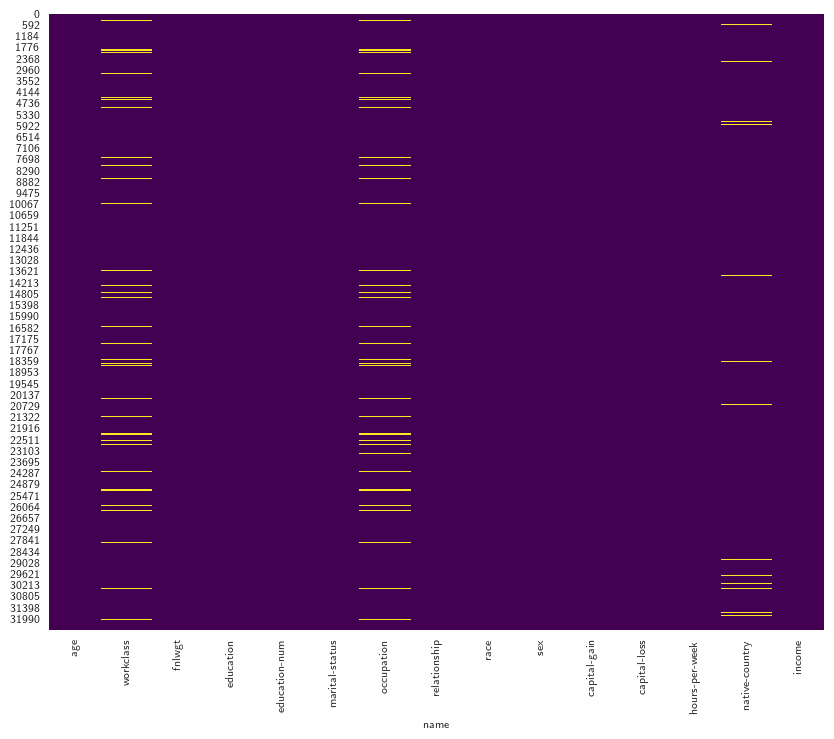

In [56]:
df_adult = df_adult.replace('\?', np.nan, regex=True)
sns.heatmap(df_adult.isna(), cbar=False, cmap='viridis')
print(f"Nombre de valeurs manquantes : {df_adult.isna().sum()}")

In [57]:
wrkclass_proportion = df_adult["workclass"].value_counts(dropna=False) / df_adult.shape[0]
print("workclass : ", wrkclass_proportion.idxmax(), f"{wrkclass_proportion.max() * 100:.2f}% ({len(wrkclass_proportion)} valeurs uniques)")
occupation_proportion = df_adult["occupation"].value_counts(dropna=False) / df_adult.shape[0]
print("occupation : ", occupation_proportion.idxmax(), f"{occupation_proportion.max() * 100:.2f}% ({len(occupation_proportion)} valeurs uniques)")
native_country_proportion = df_adult["native-country"].value_counts(dropna=False) / df_adult.shape[0]
print("native_country : ", native_country_proportion.idxmax(), f"{native_country_proportion.max() * 100:.2f}% ({len(native_country_proportion)} valeurs uniques)")
income_proportion = df_adult["income"].value_counts(dropna=False) / df_adult.shape[0]
print("income : ", income_proportion.idxmax(), f"{income_proportion.max() * 100:.2f}% ({len(income_proportion)} valeurs uniques)")

workclass :   Private 69.68% (9 valeurs uniques)
occupation :   Prof-specialty 12.71% (15 valeurs uniques)
native_country :   United-States 89.60% (42 valeurs uniques)
income :   <=50K 75.91% (2 valeurs uniques)


 ### Creation de la fonction de traitement des données

In [58]:
def treat_df(df, scaler):
    df_new = df.copy()
    # Remplacement de la valeur '?' par NaN
    df_new = df_new.replace('\?', np.nan, regex=True)
    # Remplacement des valeurs manquantes par les valeurs les plus fréquentes, les seules variables concernées sont workclass, occupation et native-country
    for col in ["workclass", "occupation", "native-country"]:
        df_new[col].fillna(df_new[col].mode()[0], inplace=True)

    categorical_columns = df_new.select_dtypes(include=['object']).columns
    numeric_columns = df_new.select_dtypes(include=['number']).columns
    # Encodage des variables catégorielles
    ordinal_encoder = OrdinalEncoder()
    for col in categorical_columns:
        if col == "income":
            continue
        df_new[col] = ordinal_encoder.fit_transform(df_new[[col]])

    # Encodage de la variable cible income
    label_encoder = LabelEncoder()
    df_new["income"] = label_encoder.fit_transform(df_new["income"])

    # Normalisation des variables numériques
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(df_new[numeric_columns])
    df_new[numeric_columns] = scaler.transform(df_new[numeric_columns])

    return df_new, scaler

## Modele de prediction

### Setup

> On pourrait faire une pipeline de pretraitement pour chaque pipeline (LabelEncoder, normalisation et drop des values NaN)

In [59]:
# Creation de différents sets
# X_train, X_test, y_train, y_test = train_test_split(df_adult_enco.drop(columns=["income"]), df_adult_enco["income"], test_size=0.2, random_state=69)
#
# # On normalise les variables quantitatives sur les données de train (StandardScaler pour l'instant)
# numerical_columns = df_adult.select_dtypes(include=['int64', 'float64']).columns
# numerical_scaler = StandardScaler()
# numerical_scaler.fit(X_train[numerical_columns])
# X_train[numerical_columns] = numerical_scaler.transform(X_train[numerical_columns])
# X_test[numerical_columns] = numerical_scaler.transform(X_test[numerical_columns])

# Import des données de test
df_adult_test = pd.read_csv("./Data/adult.test", header=None)
df_adult_test.columns = adult_columns

# Creation de différents sets (repartition 66/33 pour train/test)
df_adult_new, fitted_scaler = treat_df(df_adult, None)
X_train, y_train = df_adult_new.drop(columns=["income"]), df_adult_new["income"]
df_adult_test_new, _ = treat_df(df_adult_test, fitted_scaler)
X_test, y_test = df_adult_test_new.drop(columns=["income"]), df_adult_test_new["income"]

def eval_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f'=== Evaluation du modèle {model.__class__.__name__} ===')
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f} (the higher the better)")
    print(f"Recall : {recall_score(y_test, y_pred):.4f} (the higher the better) (best for us)")
    print(f"R2 : {r2_score(y_test, y_pred):.4f} (the higher the better)")
    print(f"MAE : {mean_absolute_error(y_test, y_pred):.4f} (the lower the better)")
    print(f"RMSE : {mean_squared_error(y_test, y_pred):.4f} (the lower the better)")
    return y_pred

### Arbre de décision

In [60]:
from sklearn.tree import DecisionTreeClassifier

def opt_decision_tree(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    return DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion
    )

> Pas de tres bonnes performances, on va essayer avec un autre modèle.

### Random forest

In [61]:
from sklearn.ensemble import RandomForestClassifier

def opt_random_forest(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 10)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 4)
    rf_max_features = trial.suggest_categorical('rf_max_features', ['sqrt', 'log2'])
    rf_criterion = trial.suggest_categorical('rf_criterion', ['gini', 'entropy'])
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200)
    return RandomForestClassifier(
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf,
        max_features=rf_max_features,
        criterion=rf_criterion,
        n_estimators=rf_n_estimators
      )

### Regression logistique

In [62]:
from sklearn.linear_model import LogisticRegression

def opt_logistic_regression(trial):
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])

    # Filter penalties based on the solver
    penalty = "l2"  # Default penalty if an error occurs
    if solver in ['newton-cg', 'lbfgs', 'sag']:
        penalty = trial.suggest_categorical('penalty', ['l2', None])
    elif solver == 'liblinear':
        penalty = trial.suggest_categorical('penalty-liblinear', ['l1', 'l2'])
    elif solver == 'saga':
        penalty = trial.suggest_categorical('penalty-saga', ['l1', 'l2', 'elasticnet', None])
    # l1_ratio est utlisé pour l'elasticnet
    l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.5, log=True)
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    max_iter = trial.suggest_int('max_iter', 50, 500)
    return LogisticRegression(
        penalty=penalty,
        C=C,
        solver=solver,
        max_iter=max_iter,
        l1_ratio=l1_ratio,
    )

### AdaBoosting

In [63]:
from sklearn.ensemble import AdaBoostClassifier

def opt_adaboost(trial):
    base_estimator = trial.suggest_categorical('base_estimator', ['DecisionTree', 'RandomForest'])
    base_estimator_obj = None
    if base_estimator == 'DecisionTree':
        base_estimator_obj = opt_decision_tree(trial)
    elif base_estimator == 'RandomForest':
        base_estimator_obj = opt_random_forest(trial)

    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)

    return AdaBoostClassifier(
        estimator=base_estimator_obj,
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )

### Gradient boosting

In [64]:
from xgboost import XGBClassifier

def opt_gradient_boosting(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    return XGBClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )

### Stacking

In [65]:
from sklearn.ensemble import StackingClassifier

def opt_stacking(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 10)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 4)
    rf_max_features = trial.suggest_categorical('rf_max_features', ['sqrt', 'log2'])
    rf_criterion = trial.suggest_categorical('rf_criterion', ['gini', 'entropy'])
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200)

    xgb_max_depth = trial.suggest_int('xgb_max_depth', 2, 32)
    xgb_min_samples_split = trial.suggest_int('xgb_min_samples_split', 2, 10)
    xgb_min_samples_leaf = trial.suggest_int('xgb_min_samples_leaf', 1, 4)
    xgb_max_features = trial.suggest_categorical('xgb_max_features', ['sqrt', 'log2'])
    xgb_criterion = trial.suggest_categorical('xgb_criterion', ['gini', 'entropy'])
    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 50, 200)

    return StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(
                max_depth=rf_max_depth,
                min_samples_split=rf_min_samples_split,
                min_samples_leaf=rf_min_samples_leaf,
                max_features=rf_max_features,
                criterion=rf_criterion,
                n_estimators=rf_n_estimators
            )),
            ('xgb', XGBClassifier(
                max_depth=xgb_max_depth,
                min_samples_split=xgb_min_samples_split,
                min_samples_leaf=xgb_min_samples_leaf,
                max_features=xgb_max_features,
                criterion=xgb_criterion,
                n_estimators=xgb_n_estimators
            ))
        ],
        final_estimator=XGBClassifier(random_state=69)
    )

## Optimisation des hyperparamètres avec `optuna`

In [66]:
def objective(trial):
    # On choisit le classifieur à optimiser, AdaBoosting et Stackinh prennent trop de temps, on les retire pour l'instant
    classifier_name = trial.suggest_categorical('classifier', ['DecisionTree', 'RandomForest', 'LogisticRegression', 'GradientBoosting'])#, 'Stacking'])#, 'AdaBoosting'])
    # On charge les données d'entraînement et de test
    classifier_obj = None
    if classifier_name == 'DecisionTree':
        classifier_obj = opt_decision_tree(trial)
    elif classifier_name == 'RandomForest':
        classifier_obj = opt_random_forest(trial)
    elif classifier_name == 'LogisticRegression':
        classifier_obj = opt_logistic_regression(trial)
    elif classifier_name == 'AdaBoosting':
        classifier_obj = opt_adaboost(trial)
    elif classifier_name == 'GradientBoosting':
        classifier_obj = opt_gradient_boosting(trial)
    elif classifier_name == 'Stacking':
        classifier_obj = opt_stacking(trial)

    classifier_obj.fit(X_train, y_train)
    y_pred = classifier_obj.predict(X_test)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    return recall

# study = optuna.create_study(directions=["maximize", "maximize"])
# On tolère 1 chance sur 1.000.000 de se tromper
study = optuna.create_study(direction="maximize", study_name="Adult Income Prediction")
study.optimize(objective, n_trials=150)
print("Best hyperparameters: ", study.best_params)

best_model = None
if study.best_params['classifier'] == 'DecisionTree':
    best_model = opt_decision_tree(optuna.trial.FixedTrial(study.best_params))
elif study.best_params['classifier']  == 'RandomForest':
    best_model = opt_random_forest(optuna.trial.FixedTrial(study.best_params))
elif study.best_params['classifier']  == 'LogisticRegression':
    best_model = opt_logistic_regression(optuna.trial.FixedTrial(study.best_params))
elif study.best_params['classifier']  == 'AdaBoosting':
    best_model = opt_adaboost(optuna.trial.FixedTrial(study.best_params))
elif study.best_params['classifier']  == 'GradientBoosting':
    best_model = opt_gradient_boosting(optuna.trial.FixedTrial(study.best_params))
elif study.best_params['classifier']  == 'Stacking':
    best_model = opt_stacking(optuna.trial.FixedTrial(study.best_params))

best_model.fit(X_train, y_train)
eval_model(best_model, X_test, y_test)


[I 2025-06-15 16:54:47,593] A new study created in memory with name: Adult Income Prediction
[I 2025-06-15 16:54:49,994] Trial 0 finished with value: 0.6219448777951118 and parameters: {'classifier': 'GradientBoosting', 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy', 'n_estimators': 174, 'learning_rate': 0.10758096540234441}. Best is trial 0 with value: 0.6219448777951118.
[I 2025-06-15 16:54:52,473] Trial 1 finished with value: 0.6014040561622465 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 31, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 4, 'rf_max_features': 'log2', 'rf_criterion': 'gini', 'rf_n_estimators': 100}. Best is trial 0 with value: 0.6219448777951118.
[I 2025-06-15 16:54:52,512] Trial 2 finished with value: 0.2540301612064483 and parameters: {'classifier': 'DecisionTree', 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best

Best hyperparameters:  {'classifier': 'GradientBoosting', 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'gini', 'n_estimators': 98, 'learning_rate': 0.14115936220256858}
=== Evaluation du modèle XGBClassifier ===
Accuracy : 0.8737 (the higher the better)
Recall : 0.6544 (the higher the better) (best for us)
R2 : 0.3001 (the higher the better)
MAE : 0.1263 (the lower the better)
RMSE : 0.1263 (the lower the better)


array([0, 0, 0, ..., 1, 0, 1], shape=(16281,))

In [67]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(df_adult_new.drop(columns=["income"]), df_adult_new["income"], test_size=0.2)
    # On normalise les variables quantitatives sur les données de train (StandardScaler pour l'instant)
    numerical_columns = df_adult.select_dtypes(include=['int64', 'float64']).columns
    numerical_scaler = StandardScaler()
    numerical_scaler.fit(X_train[numerical_columns])
    X_train[numerical_columns] = numerical_scaler.transform(X_train[numerical_columns])
    X_test[numerical_columns] = numerical_scaler.transform(X_test[numerical_columns])

    best_model.fit(X_train, y_train)
    print(f"\n=== Evaluation num {i+1} du modèle ===")
    eval_model(best_model, X_test, y_test)


=== Evaluation num 1 du modèle ===
=== Evaluation du modèle XGBClassifier ===
Accuracy : 0.8686 (the higher the better)
Recall : 0.6464 (the higher the better) (best for us)
R2 : 0.2908 (the higher the better)
MAE : 0.1314 (the lower the better)
RMSE : 0.1314 (the lower the better)

=== Evaluation num 2 du modèle ===
=== Evaluation du modèle XGBClassifier ===
Accuracy : 0.8708 (the higher the better)
Recall : 0.6509 (the higher the better) (best for us)
R2 : 0.2859 (the higher the better)
MAE : 0.1292 (the lower the better)
RMSE : 0.1292 (the lower the better)

=== Evaluation num 3 du modèle ===
=== Evaluation du modèle XGBClassifier ===
Accuracy : 0.8686 (the higher the better)
Recall : 0.6699 (the higher the better) (best for us)
R2 : 0.2704 (the higher the better)
MAE : 0.1314 (the lower the better)
RMSE : 0.1314 (the lower the better)

=== Evaluation num 4 du modèle ===
=== Evaluation du modèle XGBClassifier ===
Accuracy : 0.8758 (the higher the better)
Recall : 0.6652 (the higher

## Evaluation du modèle


In [68]:
# Prédictions des probabilités pour la classe positive
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

### Courbe ROC

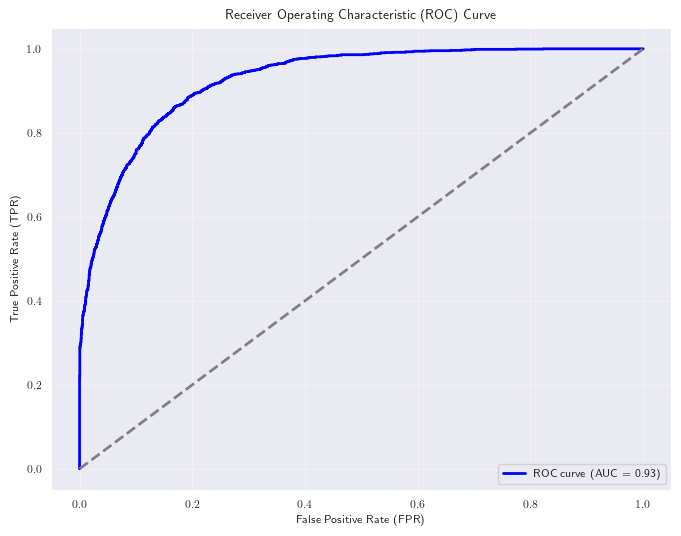

In [69]:
from sklearn.metrics import roc_curve, auc

# Calcul des FPR, TPR et seuils
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcul de l'AUC
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Ligne diagonale
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

### Courbe de précision-rappel

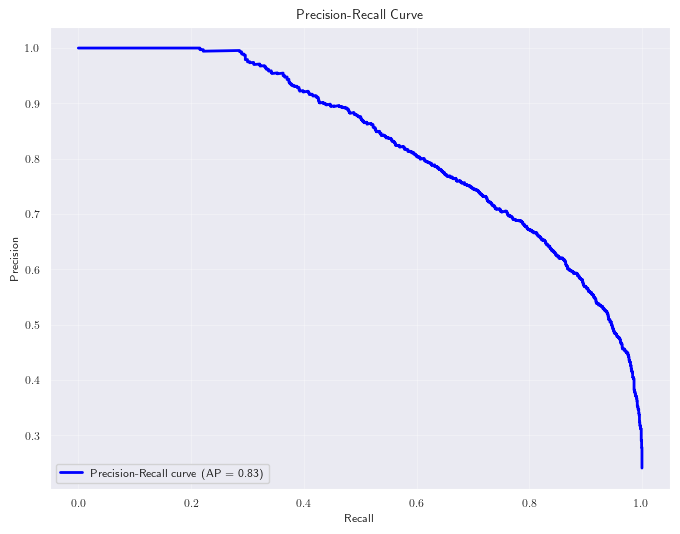

In [70]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Calcul de la precision du rappel, et des seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calcul de la moyenne de précision
avg_precision = average_precision_score(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Tracé de la courbe de précision-rappel
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

### Matrice de confusion

Pourcentage de bonnes prédictions lors d'une prédiction négative :  89.49%
Pourcentage de bonnes prédictions lors d'une prédiction positive :  77.11%


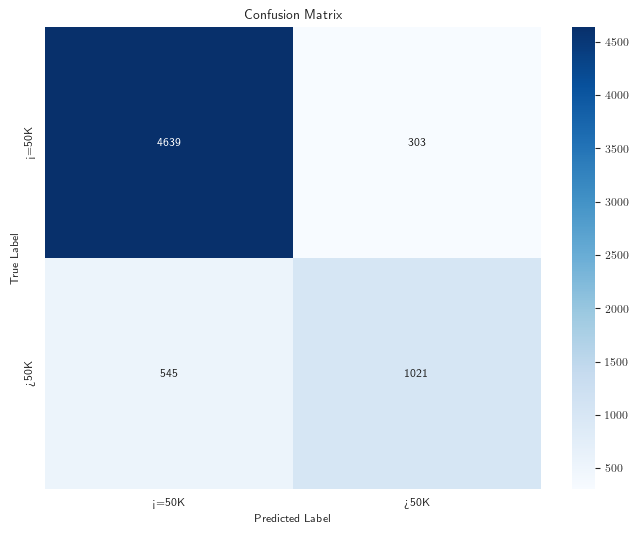

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Génération des prédictions
y_pred = best_model.predict(X_test)

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Pourcentage de bonnes prédictions lors d'une prédiction négative :  {conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0]) * 100:.2f}%")
print(f"Pourcentage de bonnes prédictions lors d'une prédiction positive :  {conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1]) * 100:.2f}%")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()